# tensorflow speech Recognition Challenge


## Library

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import csv

import tensorflow as tf
from tensorflow.keras import optimizers, losses, activations, models
from tensorflow.keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, Add, GlobalAveragePooling2D,UpSampling2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

import librosa
import librosa.display

In [4]:
classes = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'silence', 'unknown']
train_dir = 'data/train/train/audio/'

In [5]:
def split_arr(arr):
    return np.split(arr, np.arange(16000, len(arr), 16000))

def create_silence():
    
    for file in os.listdir('data/train/train/audio/_background_noise_/'):
        if 'wav' in file:
            sig, rate = librosa.load('data/train/train/audio/_background_noise_/' + file, sr = 16000)        
            sig_arr = split_arr(sig)
            if not os.path.exists(train_dir+'silence/'):
                os.makedirs(train_dir+'silence/')
            for ind, arr in enumerate(sig_arr):
                filename = 'frag%d' %ind + '_%s' %file
                librosa.output.write_wav(train_dir+'silence/'+filename, arr, 16000)

create_silence()

FileNotFoundError: [WinError 3] 지정된 경로를 찾을 수 없습니다: 'data/train/train/audio/_background_noise_/'

In [6]:
folders = os.listdir(train_dir)

all_classes = [x for x in classes[:11]]
for ind, cl in enumerate(folders):
    if cl not in classes:
        all_classes.append(cl)
print(all_classes)

['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'silence', 'bed', 'bird', 'cat', 'dog', 'eight', 'five', 'four', 'happy', 'house', 'marvin', 'nine', 'one', 'seven', 'sheila', 'six', 'three', 'tree', 'two', 'wow', 'zero']


In [7]:
with open('./data/train/train/validation_list.txt') as val_list:
    validation_list = [row[0] for row in csv.reader(val_list)]
assert len(validation_list) == 6798, 'file not loaded'


with open('./data/train/train/testing_list.txt') as test_list:
    testing_list = [row[0] for row in csv.reader(test_list)]
assert len(testing_list) == 6835, 'file not loaded'

#add silence files to validation_list
for i, file in enumerate(os.listdir(train_dir + 'silence/')):
    if i%10==0:
        validation_list.append('silence/'+file)
    if i%10==5:
        testing_list.append('silence/'+file)

training_list = []
all_files_list = []
class_counts = {}

for folder in folders:
    files = os.listdir(train_dir + folder)
    for i, f in enumerate(files):
        all_files_list.append(folder + '/' + f)
        path = folder + '/' + f
        if (path not in validation_list)&(path not in testing_list):
            training_list.append(folder + '/' + f)        
        class_counts[folder] = i


validation_list = list(set(validation_list).intersection(all_files_list))
testing_list = list(set(testing_list).intersection(all_files_list))

In [8]:
assert len(validation_list)+len(training_list) + len(testing_list)==len(all_files_list), 'error'
print('size training set: ',len(training_list)) 
print('size validation set: ', len(validation_list))
print('size testing set: ', len(testing_list))

size training set:  51409
size validation set:  6839
size testing set:  6875


In [191]:
def make_spec(file, file_dir = train_dir):
    sample, sr = librosa.load(file_dir + file, sr = 16000)
    if len(sample) < 16000: 
        sample = np.pad(sample, (0,16000-len(sample)), 'linear_ramp')
    sample = librosa.resample(sample, 16000, 8000)
    S = librosa.core.stft(sample, n_fft=1024, hop_length=256, win_length=1024)
    D = np.abs(S)**2
    mel_basis = librosa.filters.mel(8000, 1024, n_mels=40)
    mel_S = np.dot(mel_basis, D)
    log_mel_S = librosa.power_to_db(mel_S)
#     S = librosa.feature.melspectrogram(sample, sr=8000, n_mels=40)
#     log_S = librosa.power_to_db(S)
    mfcc = librosa.feature.mfcc(S=log_mel_S, n_mfcc=12)
    delta2_mfcc = librosa.feature.delta(mfcc, order=2)
    
    return delta2_mfcc.astype(np.float32) 

def create_sets(file_list):
    X_array = np.zeros([len(file_list),12,32])
    Y_array = np.zeros([len(file_list)])    
    for ind, file in enumerate(file_list):
        if ind%2000 == 0:
            print(ind, file)
#         try:
        X_array[ind] = make_spec(file)
#         except ValueError:
#             print(ind, file, ValueError)
        Y_array[ind] = all_classes.index(file.rsplit('/')[0])
        
    return X_array, Y_array

In [192]:
X_train, Y_train_all = create_sets(training_list)
Y_train = np.where(Y_train_all < 11, Y_train_all, 11)

0 bed/00176480_nohash_0.wav
2000 bird/78102205_nohash_0.wav
4000 cat/e8d562ca_nohash_1.wav
6000 down/3c257192_nohash_4.wav
8000 eight/5af0ca83_nohash_0.wav
10000 five/6cc28ce5_nohash_0.wav
12000 four/7ff085e1_nohash_0.wav
14000 go/977a3be4_nohash_0.wav
16000 happy/e652590d_nohash_0.wav
18000 left/38d78313_nohash_3.wav
20000 marvin/6add0595_nohash_1.wav
22000 nine/a0a8d759_nohash_1.wav
24000 no/b84f83d2_nohash_0.wav
26000 off/c33682f0_nohash_0.wav
28000 on/da4ef063_nohash_1.wav
30000 one/ea9f8e11_nohash_0.wav
32000 right/fc2411fe_nohash_1.wav
34000 sheila/14775481_nohash_0.wav
36000 six/36de13e1_nohash_1.wav
38000 stop/4bb1244f_nohash_1.wav
40000 three/611d2b50_nohash_0.wav
42000 tree/97f493b9_nohash_0.wav
44000 two/c5570933_nohash_0.wav
46000 up/da584bc0_nohash_4.wav
48000 yes/28ed6bc9_nohash_3.wav
50000 zero/3c257192_nohash_0.wav


In [206]:
def stretch(data, rate=1):
    input_length = len(data)
    streching = librosa.effects.time_stretch(data, rate)
    if len(streching) > input_length:
        streching = streching[:input_length]
    else:
        streching = np.pad(streching, (0, max(0, input_length - len(streching))), "constant")
    return streching

def change_pitch(data, sr):
    y_pitch = data.copy()
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change = pitch_pm * 2 * (np.random.uniform())
    y_pitch = librosa.effects.pitch_shift(y_pitch.astype('float64'), sr, n_steps=pitch_change,
                                          bins_per_octave=bins_per_octave)
    return y_pitch

def make_aug_spec(file, file_dir = train_dir, flip = False, ps = False, st = 4):
    sample, sr = librosa.load(file_dir + file, sr = 16000)
    sam_list = []
    delta_list = []
    if len(sample) < 16000: 
        sample = np.pad(sample, (0,16000-len(sample)), 'linear_ramp')
    sample = librosa.resample(sample, 16000, 8000)
    sam_list.append(change_pitch(sample, 8000))
    sam_list.append(stretch(sample, 1))
    for sam in sam_list:
        S = librosa.core.stft(sam, n_fft=1024, hop_length=256, win_length=1024)
        D = np.abs(S)**2
        mel_basis = librosa.filters.mel(8000, 1024, n_mels=40)
        mel_S = np.dot(mel_basis, D)
        log_mel_S = librosa.power_to_db(mel_S)
        mfcc = librosa.feature.mfcc(S=log_mel_S, n_mfcc=12)
        delta2_mfcc = librosa.feature.delta(mfcc, order=2)
        delta_list.append(delta2_mfcc.astype(np.float32))
    return delta_list[0],delta_list[1]

def create_aug_sets(file_list):
    X_array1 = np.zeros([len(file_list),12,32])
    X_array2 = np.zeros([len(file_list),12,32])
    Y_array = np.zeros([len(file_list)])    
    for ind, file in enumerate(file_list):
        if ind%2000 == 0:
            print(ind, file)
        try:
            X_array1[ind], X_array2[ind] = make_aug_spec(file)
        except ValueError:
            print(ind, file, ValueError)
        Y_array[ind] = all_classes.index(file.rsplit('/')[0])
        
    return np.concatenate([X_array1,X_array2]), np.concatenate([Y_array,Y_array])

In [207]:
X_train_aug, Y_train_all_aug = create_aug_sets(training_list)
Y_train_aug = np.where(Y_train_all_augl < 11, Y_train_all_aug, 11)

0 bed/00176480_nohash_0.wav
2000 bird/78102205_nohash_0.wav
4000 cat/e8d562ca_nohash_1.wav
6000 down/3c257192_nohash_4.wav
8000 eight/5af0ca83_nohash_0.wav
10000 five/6cc28ce5_nohash_0.wav
12000 four/7ff085e1_nohash_0.wav
14000 go/977a3be4_nohash_0.wav
16000 happy/e652590d_nohash_0.wav
18000 left/38d78313_nohash_3.wav
20000 marvin/6add0595_nohash_1.wav
22000 nine/a0a8d759_nohash_1.wav
24000 no/b84f83d2_nohash_0.wav
26000 off/c33682f0_nohash_0.wav
28000 on/da4ef063_nohash_1.wav
30000 one/ea9f8e11_nohash_0.wav
32000 right/fc2411fe_nohash_1.wav
34000 sheila/14775481_nohash_0.wav
36000 six/36de13e1_nohash_1.wav
38000 stop/4bb1244f_nohash_1.wav
40000 three/611d2b50_nohash_0.wav
42000 tree/97f493b9_nohash_0.wav
44000 two/c5570933_nohash_0.wav
46000 up/da584bc0_nohash_4.wav
48000 yes/28ed6bc9_nohash_3.wav
50000 zero/3c257192_nohash_0.wav


In [233]:
X_train.shape

(51409, 12, 32)

In [193]:
X_val, Y_val_all = create_sets(validation_list)
Y_val = np.where(Y_val_all < 11, Y_val_all, 11)

0 four/66774579_nohash_0.wav
2000 stop/c6ee87a7_nohash_4.wav
4000 cat/3903b558_nohash_0.wav
6000 three/48bfde8e_nohash_0.wav


In [194]:
X_test, Y_test_all = create_sets(testing_list)
Y_test = np.where(Y_test_all < 11, Y_test_all, 11)

0 zero/81dc4a94_nohash_1.wav
2000 six/48a8a69d_nohash_0.wav
4000 right/9a7c1f83_nohash_7.wav
6000 nine/d0faf7e4_nohash_3.wav


In [234]:
X_train_aug1 = np.concatenate([X_train,X_train_aug[:51409]])
Y_train_aug1 = np.concatenate([Y_train,Y_train_aug[:51409]])

In [235]:
X_train_aug1.shape

(102818, 12, 32)

In [220]:
# X_train = X_train.reshape((51409, 12, 32,1))
X_val = X_val.reshape((6839, 12, 32,1)) 
X_test = X_test.reshape((6875, 12, 32,1)) 

In [238]:
X_train_aug1 = X_train_aug1.reshape((102818, 12, 32,1))

In [241]:
from tensorflow.keras.regularizers import l2

inp = Input(shape=X_train_aug1.shape[1:])
norm_inp = BatchNormalization()(inp)
img_1 = Convolution2D(8, kernel_size=(3,3), padding = 'same', activation=activations.relu,kernel_regularizer=l2(0.01), activity_regularizer=l2(0.01))(norm_inp)
img_1 = Convolution2D(8, kernel_size=(3,3), padding = 'same',activation=activations.relu)(img_1)
img_1 = MaxPooling2D(pool_size=(2, 2))(img_1)
img_1 = Dropout(rate=0.2)(img_1)
img_1 = Convolution2D(16, kernel_size=(3,3), padding = 'same', activation=activations.relu,kernel_regularizer=l2(0.01), activity_regularizer=l2(0.01))(img_1)
img_1 = Convolution2D(16, kernel_size=(3,3), padding = 'same', activation=activations.relu)(img_1)
img_1 = MaxPooling2D(pool_size=(2, 2))(img_1)
img_1 = Dropout(rate=0.2)(img_1)
img_1 = Flatten()(img_1)

dense_1 = BatchNormalization()(Dense(128, activation=activations.relu)(img_1))
dense_1 = BatchNormalization()(Dense(128, activation=activations.relu)(dense_1))
dense_1 = Dense(12, activation=activations.softmax)(dense_1)

model = models.Model(inputs=inp, outputs=dense_1)
opt = optimizers.Adam()

model.compile(optimizer=opt, loss='categorical_crossentropy',metrics =['accuracy'])
model.summary()

Model: "model_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_55 (InputLayer)        [(None, 12, 32, 1)]       0         
_________________________________________________________________
batch_normalization_395 (Bat (None, 12, 32, 1)         4         
_________________________________________________________________
conv2d_429 (Conv2D)          (None, 12, 32, 8)         80        
_________________________________________________________________
conv2d_430 (Conv2D)          (None, 12, 32, 8)         584       
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 6, 16, 8)          0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 6, 16, 8)          0         
_________________________________________________________________
conv2d_431 (Conv2D)          (None, 6, 16, 16)         116

In [242]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss')
lrFinder = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor = 0.8, patience = 1, min_lr = 3e-5,verbose = 1)
hist1 = model.fit(X_train_aug1, to_categorical(Y_train_aug1), batch_size=128, validation_data=(X_val, to_categorical(Y_val)), epochs=30, 
          callbacks= [early_stop,lrFinder], shuffle=True, verbose=2)

Train on 102818 samples, validate on 6839 samples
Epoch 1/30
102818/102818 - 30s - loss: 1.6218 - accuracy: 0.6230 - val_loss: 0.9674 - val_accuracy: 0.7184
Epoch 2/30
102818/102818 - 29s - loss: 0.9089 - accuracy: 0.7271 - val_loss: 0.6959 - val_accuracy: 0.8019
Epoch 3/30
102818/102818 - 30s - loss: 0.7919 - accuracy: 0.7592 - val_loss: 0.6049 - val_accuracy: 0.8247
Epoch 4/30
102818/102818 - 29s - loss: 0.7268 - accuracy: 0.7757 - val_loss: 0.5668 - val_accuracy: 0.8336
Epoch 5/30
102818/102818 - 31s - loss: 0.6868 - accuracy: 0.7864 - val_loss: 0.5368 - val_accuracy: 0.8438
Epoch 6/30
102818/102818 - 29s - loss: 0.6573 - accuracy: 0.7961 - val_loss: 0.4973 - val_accuracy: 0.8510
Epoch 7/30
102818/102818 - 29s - loss: 0.6379 - accuracy: 0.8014 - val_loss: 0.4971 - val_accuracy: 0.8561
Epoch 8/30
102818/102818 - 28s - loss: 0.6201 - accuracy: 0.8073 - val_loss: 0.4831 - val_accuracy: 0.8544
Epoch 9/30
102818/102818 - 28s - loss: 0.6080 - accuracy: 0.8097 - val_loss: 0.5023 - val_accu

W0615 14:18:51.024853 18888 callbacks.py:1250] Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.plot(hist1.history['loss'])
plt.plot(hist1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.subplot(122)
plt.plot(hist1.history['accuracy'])
plt.plot(hist1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [127]:
results = model.evaluate(X_test, to_categorical(Y_test), batch_size=128)

6875/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [60]:
y_pred = model.predict(X_train)

In [68]:
np.argmax(y_pred,1)

51409

In [42]:
model.save('data/cnn2d_model.h5')

(12.0, 0.0)

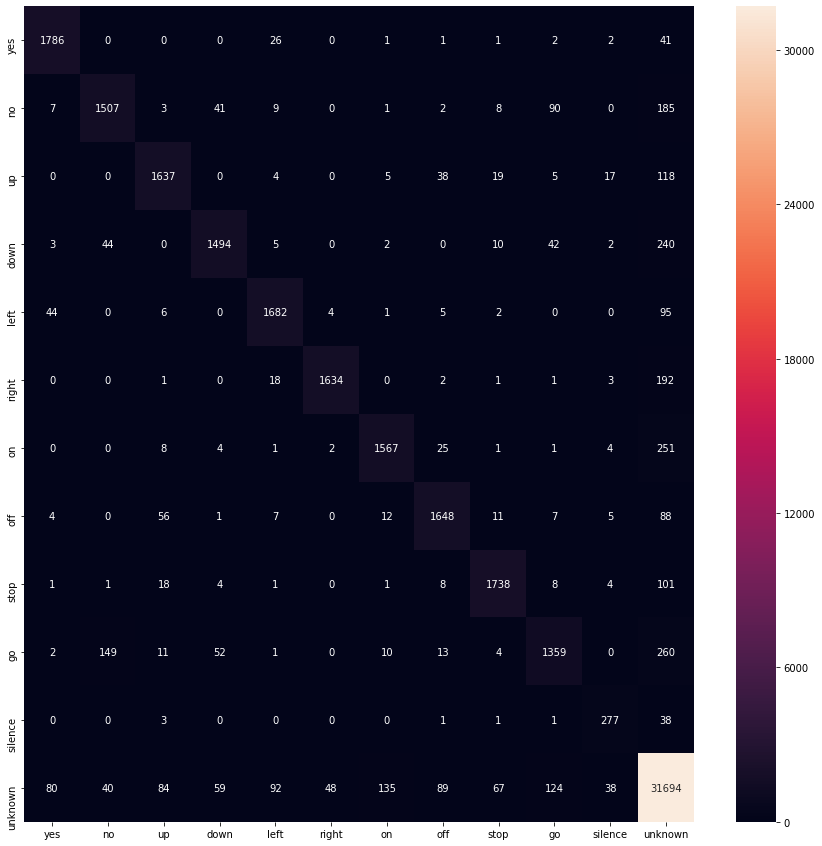

In [61]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(15,15))
ax = sns.heatmap(confusion_matrix(Y_train, np.argmax(y_pred,1)), annot=True, fmt="d" 
                  ,yticklabels=classes, xticklabels=classes
                )
buttom, top = ax.get_ylim()
ax.set_ylim(buttom+0.5,top-0.5)

(12.0, 0.0)

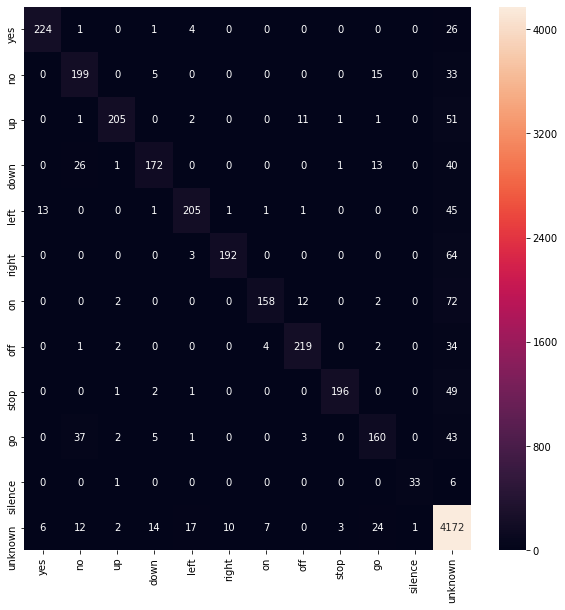

In [129]:
y_pred = model.predict(X_test)
plt.figure(figsize=(10,10))
ax = sns.heatmap(confusion_matrix(Y_test, np.argmax(y_pred,1)), annot=True, fmt="d" 
                  ,yticklabels=classes, xticklabels=classes
                )
buttom, top = ax.get_ylim()
ax.set_ylim(buttom+0.5,top-0.5)

In [130]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, np.argmax(y_pred,1)))

              precision    recall  f1-score   support

         0.0       0.92      0.88      0.90       256
         1.0       0.72      0.79      0.75       252
         2.0       0.95      0.75      0.84       272
         3.0       0.86      0.68      0.76       253
         4.0       0.88      0.77      0.82       267
         5.0       0.95      0.74      0.83       259
         6.0       0.93      0.64      0.76       246
         7.0       0.89      0.84      0.86       262
         8.0       0.98      0.79      0.87       249
         9.0       0.74      0.64      0.68       251
        10.0       0.97      0.82      0.89        40
        11.0       0.90      0.98      0.94      4268

    accuracy                           0.89      6875
   macro avg       0.89      0.78      0.83      6875
weighted avg       0.89      0.89      0.89      6875



In [236]:
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.layers import Activation

def res_unit(inputs, channels):
    x = BatchNormalization()(inputs)
    x = Activation('mish')(x)
    x = Convolution2D(channels, kernel_size=(3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('mish')(x)
    x = Convolution2D(channels, kernel_size=(3,3), padding='same')(x)
    added = Add()([inputs, x])
    return added

def res_unit_stride(inputs, channels):
    x = BatchNormalization()(inputs)
    x = Activation('mish')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Convolution2D(channels, kernel_size=(3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('mish')(x)
    x = Convolution2D(channels, kernel_size=(3,3), padding='same')(x)
    conv = Convolution2D(channels, kernel_size=(3,3), strides=(2,2), padding='same')(inputs)
    added = Add()([conv, x])
    return added

def get_encoder(shape=(12, 32, 1)):
    inp = Input(shape=shape)
    x = BatchNormalization()(inp)
    x =  res_unit(x, 16)
    x =  res_unit_stride(x, 32)
    x =  res_unit(x, 32)
    x =  res_unit_stride(x, 64)

    return models.Model(inp, x)

def get_decoder(shape=(3, 8, 64)):
    inp = Input(shape=shape)

    x = UpSampling2D((2, 2))(inp)
    x = Convolution2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('mish')(x)
    
    x = UpSampling2D((2, 2))(x)
    x = Convolution2D(16, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('mish')(x)
    
    x = Convolution2D(1, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    return models.Model(inp, x)
class mish(Activation):
    def __init__(self, activation, **kwargs):
        super(mish, self).__init__(activation, **kwargs)
        self.__name__ = 'mish'

def Mish(x):
    return x*K.tanh(K.softplus(x))

get_custom_objects().update({'mish': mish(Mish)})

In [156]:
seq_in = Input(shape=X_train.shape[1:])
x = BatchNormalization()(seq_in)
x =  res_unit(x, 16)
x =  res_unit(x, 16)
x =  res_unit(x, 16)
x =  res_unit_stride(x, 32)
x =  res_unit(x, 32)
x =  res_unit(x, 32)
x =  res_unit(x, 32)
x =  res_unit_stride(x, 64)

In [ ]:
encoder = get_encoder((12, 32, 1))
decoder = get_decoder((3, 8, 64))
seq_in = Input(shape=X_train.shape[1:])
x = encoder(seq_in)
d = decoder(x)

res_model = models.Model(inputs=seq_in , outputs=d)

In [231]:
res_model.summary()

Model: "model_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_51 (InputLayer)        [(None, 12, 32, 1)]       0         
_________________________________________________________________
model_30 (Model)             (None, 3, 8, 64)          114328    
_________________________________________________________________
model_31 (Model)             (None, 12, 32, 1)         23425     
Total params: 137,753
Trainable params: 137,205
Non-trainable params: 548
_________________________________________________________________


In [240]:
res_model.compile(optimizer=optimizers.Nadam(lr=1e-3, schedule_decay=1e-5), loss='mse')
early_stop = tf.keras.callbacks.EarlyStopping(patience=1, monitor='loss')
res_model.fit(X_train_aug1, X_train_aug1, batch_size=1024, epochs=5, 
          callbacks= [early_stop], shuffle=True, verbose=2)

Train on 102818 samples
Epoch 1/5


W0615 13:53:04.156002 18888 callbacks.py:1250] Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss


102818/102818 - 248s - loss: 0.0452
Epoch 2/5


W0615 13:57:24.894157 18888 callbacks.py:1250] Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss


102818/102818 - 261s - loss: 0.0411
Epoch 3/5


W0615 14:01:47.395744 18888 callbacks.py:1250] Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss


102818/102818 - 263s - loss: 0.0369
Epoch 4/5


W0615 14:06:04.418120 18888 callbacks.py:1250] Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss


102818/102818 - 257s - loss: 0.0360
Epoch 5/5


W0615 14:10:17.033161 18888 callbacks.py:1250] Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss


102818/102818 - 253s - loss: 0.0330


In [243]:
new_train = res_model.predict(X_train_aug1)

In [250]:
new_train.shape

(102818, 12, 32, 1)

In [262]:
seq_in1 = Input(shape=new_train.shape[1:])
y = BatchNormalization()(seq_in1)
y =  res_unit(y, 16)
y =  res_unit(y, 16)
y =  res_unit_stride(y, 32)
y =  res_unit(y, 32)
y =  res_unit(y, 32)
y =  res_unit_stride(y, 64)
y = BatchNormalization()(y)
y = Activation('mish')(y)
y = GlobalAveragePooling2D()(y)
y = Flatten()(y)
y = Dense(64, kernel_initializer='he_normal', activation='mish')(y)
seq_out1 = Dense(12, activation=activations.softmax)(y)
rmodel = models.Model(inputs=seq_in1, outputs=seq_out1)
rmodel.compile(optimizer=opt, loss='categorical_crossentropy',metrics =['accuracy'])
rmodel.summary()

Model: "model_37"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_64 (InputLayer)           [(None, 12, 32, 1)]  0                                            
__________________________________________________________________________________________________
batch_normalization_450 (BatchN (None, 12, 32, 1)    4           input_64[0][0]                   
__________________________________________________________________________________________________
batch_normalization_451 (BatchN (None, 12, 32, 1)    4           batch_normalization_450[0][0]    
__________________________________________________________________________________________________
activation_384 (Activation)     (None, 12, 32, 1)    0           batch_normalization_451[0][0]    
___________________________________________________________________________________________

In [258]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss')
lrFinder = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor = 0.8, patience = 1, min_lr = 3e-5,verbose = 1)
hist2 = rmodel.fit(new_train, to_categorical(Y_train_aug1), batch_size=1024, validation_data=(X_val, to_categorical(Y_val)), epochs=30, 
          callbacks= [early_stop,lrFinder], shuffle=True, verbose=2)

Train on 102818 samples, validate on 6839 samples
Epoch 1/30
102818/102818 - 249s - loss: 0.4614 - accuracy: 0.8474 - val_loss: 0.4504 - val_accuracy: 0.8535
Epoch 2/30
102818/102818 - 250s - loss: 0.3273 - accuracy: 0.8917 - val_loss: 0.4614 - val_accuracy: 0.8545
Epoch 3/30
102818/102818 - 254s - loss: 0.2767 - accuracy: 0.9088 - val_loss: 0.3145 - val_accuracy: 0.8941
Epoch 4/30
102818/102818 - 256s - loss: 0.2437 - accuracy: 0.9189 - val_loss: 0.3291 - val_accuracy: 0.8949
Epoch 5/30
102818/102818 - 258s - loss: 0.2204 - accuracy: 0.9268 - val_loss: 0.2855 - val_accuracy: 0.9057
Epoch 6/30
102818/102818 - 261s - loss: 0.1980 - accuracy: 0.9353 - val_loss: 0.3055 - val_accuracy: 0.9077
Epoch 7/30
102818/102818 - 254s - loss: 0.1823 - accuracy: 0.9396 - val_loss: 0.3193 - val_accuracy: 0.9000


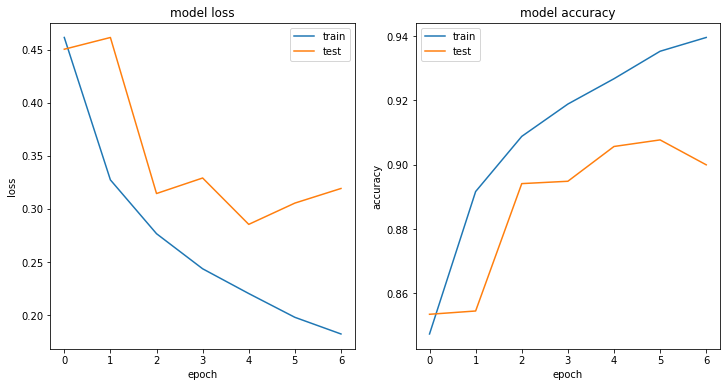

In [260]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.subplot(122)
plt.plot(hist2.history['accuracy'])
plt.plot(hist2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [261]:
results = rmodel.evaluate(X_test, to_categorical(Y_test), batch_size=1024)

6875/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [263]:
rmodel.save('data/res_cnn_model.h5')